In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os

from tsai.all import *
computer_setup()

os             : Linux-4.15.0-70-generic-x86_64-with-glibc2.10
python         : 3.8.5
tsai           : 0.2.24
fastai         : 2.5.3
fastcore       : 1.3.27
torch          : 1.8.1+cu101
n_cpus         : 96
device         : cuda (Tesla V100-SXM2-32GB)


In [2]:
class_map = {
    '1':'Nor',  # N:1  - Normal
    '2':'RoT',  # r:2  - R-on-T premature ventricular contraction
    '3':'PVC',  # V:3  - Premature ventricular contraction
    '4':'SPC',  # S:4  - Supraventricular premature or ectopic beat (atrial or nodal)
    '5':'Unk',  # Q:5  - Unclassifiable beat
    }
class_map

{'1': 'Nor', '2': 'RoT', '3': 'PVC', '4': 'SPC', '5': 'Unk'}

In [3]:
# dataset id
dsid = 'ECG5000' 
X, y, splits = get_UCR_data(dsid, split_data=False)
labeler = ReLabeler(class_map)
new_y = labeler(y) # map to more descriptive labels
X.shape, new_y.shape, splits, new_y

((5000, 1, 140),
 (5000,),
 ((#500) [0,1,2,3,4,5,6,7,8,9...],
  (#4500) [500,501,502,503,504,505,506,507,508,509...]),
 array(['Nor', 'Nor', 'Nor', ..., 'RoT', 'RoT', 'RoT'], dtype='<U3'))

In [8]:
label_counts = collections.Counter(new_y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'Nor': 2919, 'RoT': 1767, 'PVC': 96, 'SPC': 194, 'Unk': 24}
Naive Accuracy: 58.38%


In [9]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

(#500) [(TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0)), (TSTensor(vars:1, len:140, device=cpu), TensorCategory(0))] ...]

SuggestedLRs(valley=0.0012022644514217973)

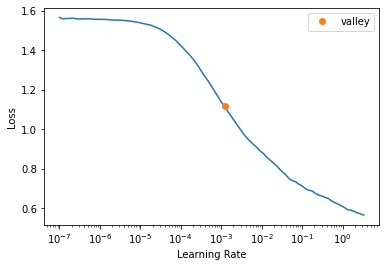

In [10]:
model = build_ts_model(InceptionTimePlus, dls=dls)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find()

In [11]:
learn = ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy)
learn.fit_one_cycle(30, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.496262,1.645582,0.346000,00:00
1,1.235263,1.614043,0.353111,00:00
2,0.999045,1.446443,0.353333,00:00
3,0.822071,1.058446,0.606444,00:00
4,0.687910,1.352069,0.387333,00:00
5,0.589809,0.278919,0.931333,00:00
6,0.511856,0.233791,0.931111,00:00
7,0.453245,0.256793,0.932000,00:00
8,0.401321,0.254903,0.934222,00:00
9,0.360504,0.228143,0.936667,00:00


SuggestedLRs(valley=0.00019054606673307717)

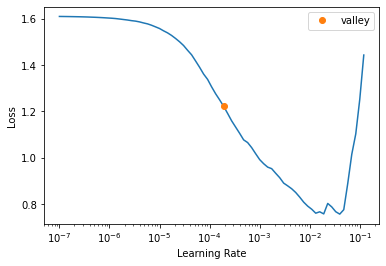

In [12]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocket, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.448233,1.599729,0.353556,00:00
1,1.198403,1.464065,0.766667,00:00
2,0.950061,1.171477,0.864222,00:00
3,0.767685,0.789022,0.891556,00:00
4,0.637467,0.549727,0.909111,00:00
5,0.534349,0.363102,0.921111,00:00
6,0.460500,0.303972,0.925556,00:00
7,0.396720,0.252093,0.941111,00:00
8,0.343897,0.234013,0.939556,00:00
9,0.299401,0.227042,0.941111,00:00


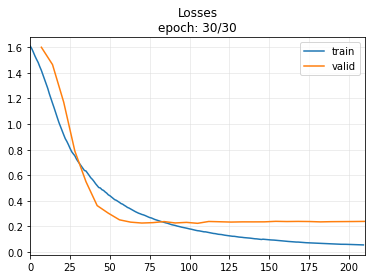

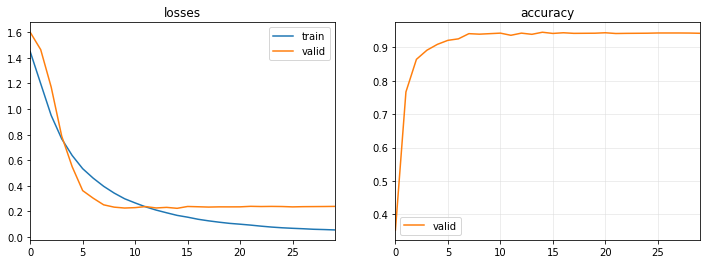

Total time        : 0:00:23.723542


In [13]:
tfms = [None, TSClassification()]
batch_tfms = [TSStandardize(by_sample=True), TSMagScale()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms)
model = build_ts_model(MiniRocket, dls=dls)
learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
timer.start()
learn.fit_one_cycle(30, 3e-4)
timer.stop()